Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9845 entries, 0 to 9844
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  9845 non-null   object
 1   label     9845 non-null   object
dtypes: object(2)
memory usage: 154.0+ KB
None

All Data:
                                                      filename   label
                                              a.0JWo-James.jpg       a
                                      a.0xvU-Lutian Grace .jpg       a
                                              a.11PX-James.jpg       a
                                              a.1CQN-James.jpg       a
                                      a.1Jjh-Lutian Grace .jpg       a
                                              a.2aoN-James.jpg       a
                                      a.2cqF-Luntian Grace.jpg       a
                                              a.30tp-James.jpg       a
                            

C:\Users\Sam\AppData\Local\Temp\ipykernel_23496\858482260.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=char_df, x='character', y='count', palette='crest')


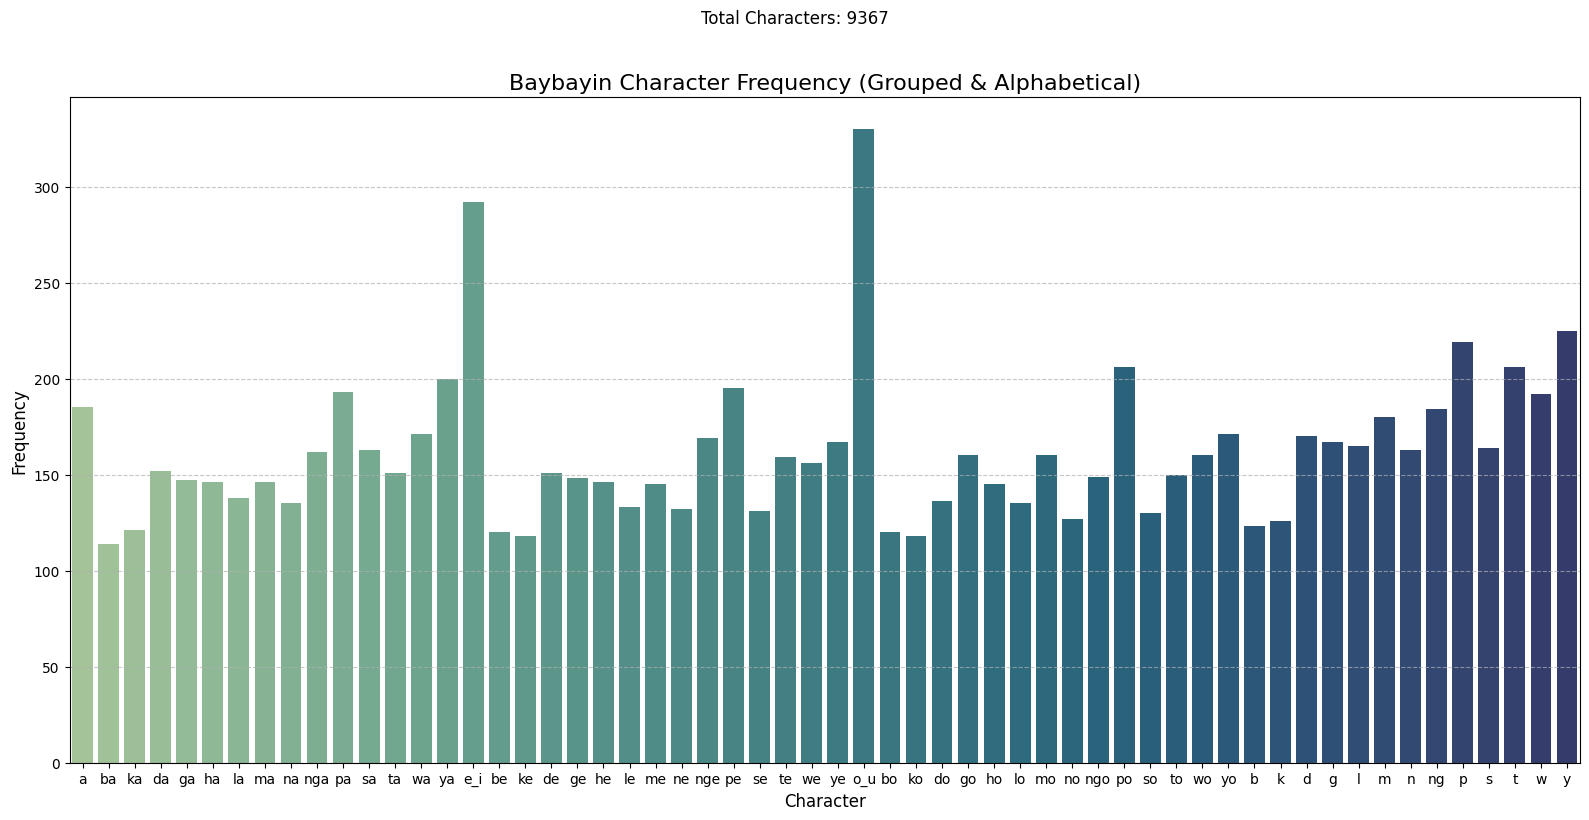

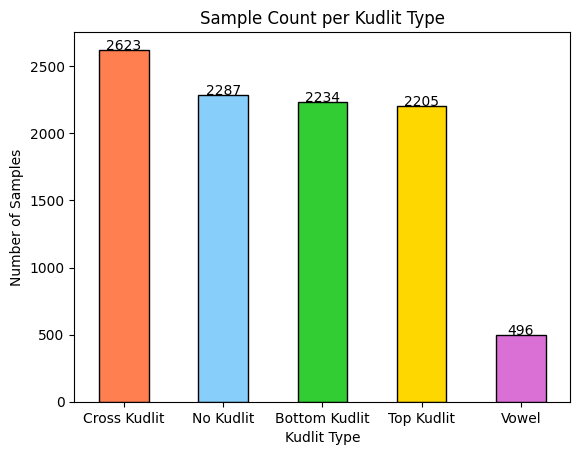

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import cv2
import numpy as np

# Load CSV File with Labels
csv_file = "pics_labels.csv"
df = pd.read_csv(csv_file)

if 'filename' not in df.columns or 'label' not in df.columns:
    print("CSV file must contain 'filename' and 'label' columns.")
    exit()

print("Dataset Summary:")
print(df.info())
print("\nAll Data:")
print(df.to_string(index=False))

# Kudlit Detection Section
def detect_kudlits(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return {"top_kudlit": 0, "bottom_kudlit": 0, "cross_under": 0}

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    height = img.shape[0]
    top_kudlit = 0
    bottom_kudlit = 0
    cross_under = 0

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        if area < 150:
            center_y = y + h // 2
            if center_y < height * 0.3:
                top_kudlit += 1
            elif center_y > height * 0.7:
                bottom_kudlit += 1
                aspect_ratio = w / float(h)
                if 0.8 < aspect_ratio < 1.2:
                    cross_under += 1

    return {
        "top_kudlit": top_kudlit,
        "bottom_kudlit": bottom_kudlit,
        "cross_under": cross_under
    }

# Process all images
image_folder = "Dataset"
kudlit_data = []

for _, row in df.iterrows():
    image_path = os.path.join(image_folder, row['filename'])
    kudlit_info = detect_kudlits(image_path)
    kudlit_data.append(kudlit_info)

# Merge kudlit info
df = pd.concat([df, pd.DataFrame(kudlit_data)], axis=1)

print("\nData with kudlit detection:")
print(df.to_string(index=False))

# 3. Baybayin Character Frequency (Grouped and Alphabetical)

# Define the full list of Baybayin characters, including those for the variants
baybayin_letters = [
    'a', 'ba', 'ka', 'da', 'ga', 'ha', 'la', 'ma', 'na', 'nga', 'pa', 'sa', 'ta', 'wa', 'ya',
    'e_i', 'be', 'ke', 'de', 'ge', 'he', 'le', 'me', 'ne', 'nge', 'pe', 'se', 'te', 'we', 'ye',
    'o_u', 'bo', 'ko', 'do', 'go', 'ho', 'lo', 'mo', 'no', 'ngo', 'po', 'so', 'to', 'wo', 'yo',
    'b', 'k', 'd', 'g', 'l', 'm', 'n', 'ng', 'p', 's', 't', 'w', 'y'
]

# Flatten the labels from the DataFrame and normalize
labels = df['label'].str.replace('-', '').str.split('_').explode().dropna()

# Normalize the characters to match the defined Baybayin letters (e.g., 'e' and 'i' -> 'e_i', 'o' and 'u' -> 'o_u')
def normalize_baybayin_char(char):
    if char in ['e', 'i']:
        return 'e_i'
    elif char in ['o', 'u']:
        return 'o_u'
    return char

normalized_labels = labels.apply(normalize_baybayin_char)

# Count the occurrences of each character in the normalized dataset
char_counts = normalized_labels.value_counts().to_dict()

# Ensure that all Baybayin letters are represented in the count (even if a character has zero occurrences)
char_counts_complete = {char: char_counts.get(char, 0) for char in baybayin_letters}

# Convert the counts into a DataFrame for easy visualization
char_df = pd.DataFrame(list(char_counts_complete.items()), columns=['character', 'count'])

# Visualize the Baybayin character frequency data
plt.figure(figsize=(16, 8))
sns.barplot(data=char_df, x='character', y='count', palette='crest')

plt.title("Baybayin Character Frequency (Grouped & Alphabetical)", fontsize=16)
plt.xlabel("Character", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle(f"Total Characters: {char_df['count'].sum()}", fontsize=12, y=1.02)

plt.tight_layout()
plt.show()


# 🔎 Label Group Classification (based on kudlit type and label content)

# Define your categories with numbers for clarity
vowel = ['a', 'e_i', 'o_u']  # Vowel
no_kudlit = ['ba', 'ka', 'da_ra', 'ga', 'ha', 'la', 'ma', 'na', 'nga', 'pa', 'ra', 'sa', 'ta', 'wa', 'ya']  # No Kudlit
top_kudlit = ['be_bi', 'ke_ki', 'de_di', 'ge_gi', 'he_hi', 'le_li', 'me_mi', 'ne_ni', 'nge_ngi', 'pe_pi', 're_ri', 'se_si', 'te_ti', 'we_wi', 'ye_yi']  # Top Kudlit
bot_kudlit = ['bo_bu', 'ko_ku', 'do_du', 'go_gu', 'ho_hu', 'lo_lu', 'mo_mu', 'no_nu', 'ngo_ngu', 'po_pu', 'ro_ru', 'so_su', 'to_tu', 'wo_wu', 'yo_yu']  # Bottom Kudlit
cross_kudlit = ['b', 'k', 'd', 'g', 'h', 'l', 'm', 'n', 'ng', 'p', 'r', 's', 't', 'w', 'y']  # Cross Kudlit

# Function to classify each label into a group
def classify_kudlit(label):
    if label in no_kudlit:
        return 'No Kudlit'
    elif label in top_kudlit:
        return 'Top Kudlit'
    elif label in bot_kudlit:
        return 'Bottom Kudlit'
    elif label in cross_kudlit:
        return 'Cross Kudlit'
    elif label in vowel:
        return 'Vowel'
    else:
        return 'Unknown'

# Apply classification
df['kudlit_type'] = df['label'].apply(classify_kudlit)

# Plot histogram
counts = df['kudlit_type'].value_counts()

# Choose a color palette for the bars
colors = ['#FF7F50', '#87CEFA', '#32CD32', '#FFD700', '#DA70D6']  # A mix of vibrant colors

ax = counts.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Sample Count per Kudlit Type')
plt.xlabel('Kudlit Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)

# Add the count on top of each bar
for i, count in enumerate(counts):
    ax.text(i, count + 0.2, str(count), ha='center', fontsize=10)

plt.show()

